In [1]:
import pdb
import pycm
import sys
sys.path.append('../')
from glob import glob
import torch
import scipy
from torch import nn
import cv2
from tqdm import tqdm_notebook as tqdm
import os
# from models import Model
from PIL import Image
from skimage import io, transform
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from torchvision.datasets.folder import pil_loader
from torchvision import transforms
import random
import numpy as np
from torchsummary import summary
import pretrainedmodels
from sklearn.model_selection import KFold, StratifiedKFold
from efficientnet_pytorch import EfficientNet
import albumentations
from pycm import ConfusionMatrix
from tensorboard_logger import * 
import warnings
warnings.filterwarnings("ignore")
from models import *
from utils import *
import albumentations
from albumentations import torch as AT
os.environ['CUDA_VISIBLE_DEVICES']=""
from dataloader import provider
from augmentations import *
from mask_functions import *
import warnings
# warnings.filterwarnings('ignore', category=RuntimeWarning)

%matplotlib inline


#### Loss weight test

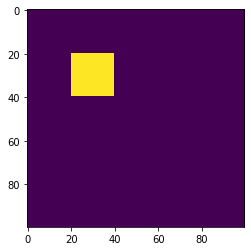

In [110]:
label = np.zeros([1, 100, 100])
label[0, 20:40, 20:40] = np.ones([20, 20])
plt.imshow(label[0])

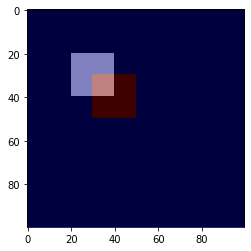

In [111]:
pred = np.zeros([1, 100, 100]) + 0.1
pred[0, 30:50, 30:50] = np.ones([20, 20]) - 0.1
plt.imshow(label[0], cmap='gray') 
plt.imshow(pred[0], alpha=0.5, cmap='jet')

In [37]:
pred, label

(array([[[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
         ...,
         [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]]]),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]))

In [112]:
logit = torch.Tensor(pred)
truth = torch.Tensor(label)

In [42]:
logit = logit.view(-1)
truth = truth.view(-1)

In [44]:
logit.shape, truth.shape

(torch.Size([10000]), torch.Size([10000]))

In [48]:
logit[:100], truth[:100]

(tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [65]:
loss = F.binary_cross_entropy_with_logits(logit, truth, reduction='none')
loss, loss.shape, np.unique(loss), loss.mean()

(tensor([0.7444, 0.7444, 0.7444,  ..., 0.7444, 0.7444, 0.7444]),
 torch.Size([10000]),
 array([0.34115392, 0.64439666, 0.7443967 , 1.241154  ], dtype=float32),
 tensor(0.7523))

In [50]:
pos = (truth > 0.5).float()
neg = (truth < 0.5).float()
pos_weight = pos.sum().item() + 1e-12
neg_weight = neg.sum().item() + 1e-12


In [58]:
pos.shape, pos_weight, neg_weight # positive and negative count

(torch.Size([10000]), 400.000000000001, 9600.000000000002)

In [67]:
0.9*pos_weight, 0.1*neg_weight # weight to positive class and negative class

(360.0000000000009, 960.0000000000002)

In [66]:
loss = (0.9*pos*loss/pos_weight + 0.1*neg*loss/neg_weight).sum()
loss

tensor(0.5877)

testing metric, re initialize truth and logits

In [98]:
np.unique(torch.sigmoid(torch.Tensor(pred)))

array([0.5249792, 0.7109495], dtype=float32)

In [113]:
threshold=0.6 # sigmoid(0) = 0.5
reduction='none'
batch_size = len(truth)
logit = torch.Tensor([pred, pred, pred])
truth = torch.Tensor([label, label, label])
logit = logit.view(batch_size, -1)
truth = truth.view(batch_size, -1)
assert(logit.shape == truth.shape)


In [114]:
probability = torch.sigmoid(logit)
p = (probability > threshold).float()
t = (truth > 0.5).float()


In [115]:
p.shape, t.shape, 

(torch.Size([1, 30000]), torch.Size([1, 30000]))

In [109]:
p, t, np.unique(t), np.unique(p)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32))

In [116]:
t_sum = t.sum(-1)
p_sum = p.sum(-1)
neg_index = torch.nonzero(t_sum == 0) # negative images in the batch
pos_index = torch.nonzero(t_sum >= 1) # positive images in the batch
print(len(neg_index), len(pos_index))

0 1


In [ ]:
dice_neg = (p_sum == 0).float() # comp metric: dice for empty image with zero pred is 1
dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

dice_neg = dice_neg[neg_index]
dice_pos = dice_pos[pos_index]
dice = torch.cat([dice_pos, dice_neg])

dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
dice = dice.mean().item()

num_neg = len(neg_index)
num_pos = len(pos_index)

 dice, dice_neg, dice_pos, num_neg, num_pos

#### Dice score testing

In [10]:

def compute_dice(outputs, target):
    eps = 0.0001
    inter = np.sum(outputs * target)
    union = np.sum(outputs) + np.sum(target) + eps
    t = (2 * inter + eps) / union
    return t


def compute_dice_batch(outputs, labels):
    dices = []
    preds = outputs.clone() # copy is imp
    for pred, label in zip(preds, labels):
        dices.append(compute_dice(pred, label))
    dice = np.nanmean(dices)
    return dice

def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector. This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 0.0001

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat)
    B_sum = torch.sum(tflat)
    
    return ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

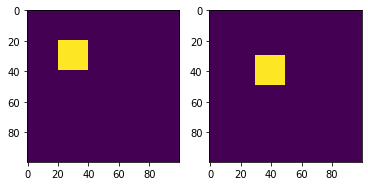

In [8]:
pred = np.zeros([100, 100])
pred1 = np.zeros([100, 100])
pred2 = np.zeros([100, 100])
label = np.zeros([100, 100])
pred[20:40, 20:40] = np.ones([20, 20])
pred1[25:45, 30:50] = np.ones([20, 20])
pred2[35:55, 40:60] = np.ones([20, 20])
label[30:50, 30:50] = np.ones([20, 20])
plt.subplot(1, 2, 1)
plt.imshow(pred)
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.show()

In [12]:
preds = np.array([pred, pred1, pred2, pred, pred1, pred2, pred, pred1, pred2, ])
labels = np.array([label, label, label, pred1, pred2, pred, pred1, pred2, pred, ])
# preds = torch.FloatTensor(preds)
# labels = torch.FloatTensor(labels)

In [13]:
#compute_dice_batch(preds, labels),  
compute_dice(preds, labels)

0.2916666765046295

In [15]:
preds.shape, labels.shape

((9, 100, 100), (9, 100, 100))

In [28]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.reshape(n, -1)
    targs = targs.reshape(n, -1)
    intersect = (preds * targs).sum(-1)#.float()
    print(intersect.dtype)
    union = (preds+targs).sum(-1)#.float()
    print(union.dtype)
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return np.mean(2. * intersect / union)

In [29]:
dice_overall(preds, labels)

float64
float64


0.2916666666666667

In [34]:
path = '../data/test_png/1.2.276.0.7230010.3.1.4.8323329.5797.1517875190.762694.png'
img = cv2.imread(path)
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # (512, 512)
image = np.expand_dims(image, -1)
image = np.repeat(image, 3, axis=-1)
image.shape

(1024, 1024, 3)

In [33]:
np.equal(img, image).all()

True

#### train df, groups, testing

In [ ]:
img1 = cv2.imread('../data/train_png/1.2.276.0.7230010.3.1.4.8323329.10130.1517875222.282238.png')
img2 = cv2.imread('../data/train_png/1.2.276.0.7230010.3.1.4.8323329.10130.1517875222.282238.png',cv2.IMREAD_GRAYSCALE)


In [ ]:
img1.shape, img2.shape

In [ ]:
plt.imshow(img1); plt.show()
plt.imshow(img2); plt.show()

In [14]:
df = pd.read_csv('../data/train.csv')

In [15]:
df.head()

,ImageId,EncodedPixels,has_mask
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,0
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...,1
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...,1
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...,1


In [18]:
df_with_mask = df.query('has_mask == 1')

In [19]:
df_with_mask.shape

(3286, 3)

In [20]:
df_without_mask = df.query('has_mask==0')

In [26]:
df_without_mask.shape

(8296, 3)

In [34]:
df_wom_sampled = df_without_mask.sample(len(df_with_mask))

In [31]:
df_wom_sampled.shape

(3286, 3)

In [36]:
equal_df = pd.concat([df_with_mask, df_wom_sampled])

In [38]:
equal_df.describe()

,has_mask
count,6572.000000
mean,0.500000
std,0.500038
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
df.iloc[2]['ImageId']

In [ ]:
gb = df.groupby('ImageId')

In [ ]:
uid = list(gb.groups.keys())
len(uid)

In [ ]:
gb.get_group(uid[3])['EncodedPixels'].tolist()

In [ ]:
df['ImageId'].nunique(), df.shape

In [ ]:
image_id = '1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709' 
arr = df.loc[df['ImageId'] == image_id, 'EncodedPixels'].values

In [ ]:
arr

In [ ]:
df['EncodedPixels'][0]

In [ ]:
#df['EncodedPixels'] = df['EncodedPixels'].str.lstrip(to_strip=None)

In [13]:
#df.to_csv('../data/train.csv', index=False)

NameError: name 'df' is not defined

### IoUs testing

In [2]:
def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''`classes` is a list of class labels, ignore background class i.e., 0, foregrounds: 1, 2.. example classes=[1, 2]'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(preds, labels, classes=None):
    iou = np.nanmean([compute_ious(pred, label, classes)[0] for pred, label in zip(preds, labels)])
    return iou


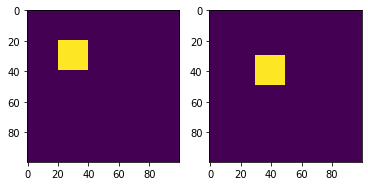

In [3]:
pred = np.zeros([100, 100])
label = np.zeros([100, 100])
pred[20:40, 20:40] = np.ones([20, 20])
label[30:50, 30:50] = np.ones([20, 20])
plt.subplot(1, 2, 1)
plt.imshow(pred)
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.show()

In [4]:
iou = compute_ious(pred, label, [1])
print(iou)
iou = compute_ious(pred.flatten(), label.flatten(), [1])
print(iou)
pred.dtype, label.dtype

[0.14285714285714285]
[0.14285714285714285]


(dtype('float64'), dtype('float64'))

In [5]:
preds = np.array([pred, pred, pred])
labels = np.array([label, label, label])
compute_iou_batch(preds, labels, classes=[1])

0.14285714285714285

In [6]:
preds.shape, labels.shape

((3, 100, 100), (3, 100, 100))

In [33]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union 
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        print(iou)
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        print('l', iou)
        
        metric += iou
        
    # teake the average over all images in batch
        print('metric', metric)
    metric /= batch_size
    return metric

In [34]:
preds = np.array([pred, pred1, pred2, pred, pred1, pred2, pred, pred1, pred2, ])
labels = np.array([label, label, label, pred1, pred2, pred, pred1, pred2, pred ])

In [30]:
preds.shape, labels.shape

((9, 100, 100), (9, 100, 100))

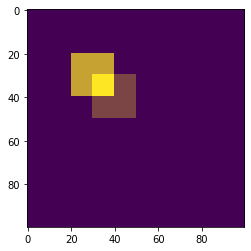

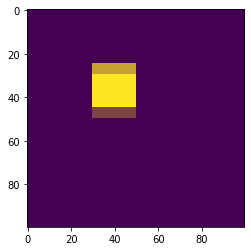

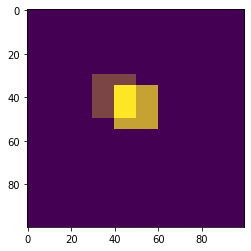

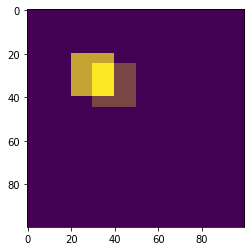

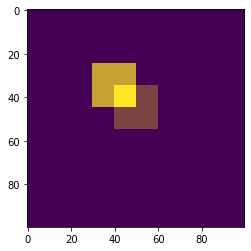

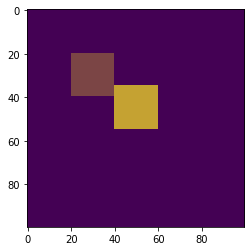

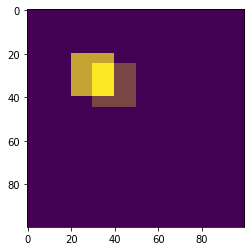

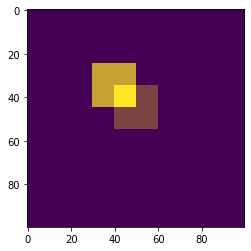

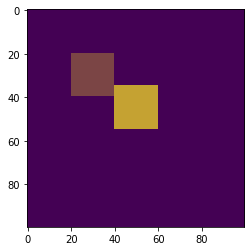

In [31]:
for i in range(len(preds)):
    plt.imshow(preds[i])
    plt.imshow(labels[i], alpha=0.3)
    plt.show()

In [35]:
get_iou_vector(labels, preds)

0.14285714285714285
l 0.0
metric 0.0
0.6
l 0.2
metric 0.2
0.23076923076923078
l 0.0
metric 0.2
0.23076923076923078
l 0.0
metric 0.2
0.14285714285714285
l 0.0
metric 0.2
0.0
l 0.0
metric 0.2
0.23076923076923078
l 0.0
metric 0.2
0.14285714285714285
l 0.0
metric 0.2
0.0
l 0.0
metric 0.2


0.022222222222222223

### Val set optimization

In [3]:
fold = 1
total_folds = 5
df_path = '../data/train.csv'
df = pd.read_csv(df_path)
df = df.drop_duplicates('ImageId')
df_with_mask = df.query('has_mask == 1')
#df = df_with_mask.copy()
df_without_mask = df.query('has_mask==0')
df_wom_sampled = df_without_mask.sample(len(df_with_mask))
df = pd.concat([df_with_mask, df_wom_sampled])
print(df.shape)
kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
train_idx, val_idx = list(kfold.split(
    df["ImageId"], df["has_mask"]))[fold]
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

(4758, 3)


In [16]:
val_preds1 = np.load('../weights/38_UNet_f1_512/ckpt23val1.npy')
val_preds2 = np.load('../weights/38_UNet_f1_512/ckpt23val2.npy')
val_preds1 = val_preds1[:, 0, :, :]
val_preds2 = val_preds2[:, 0, :, :]

In [19]:
val_preds = np.concatenate([val_preds1, val_preds2], axis=0)
del val_preds1, val_preds2
val_preds.shape

SyntaxError: invalid syntax (<ipython-input-19-a9906ac5ea5b>, line 2)

In [18]:
val_actual = []
val_ids = val_df['ImageId'].values
root = '../data/'
for idx, image_id in enumerate(tqdm(val_ids)):
    mask_path = os.path.join(root, "npy_masks_512", image_id + '.npy')
    mask = np.load(mask_path)
    #mask = cv2.resize(mask, (256, 256))
    val_actual.append(mask)
    #if (idx + 1) == len(val_preds): break
val_actual = np.array(val_actual)

100%|██████████| 952/952 [00:06<00:00, 146.84it/s] 


In [21]:
val_actual.shape, val_preds.shape

((952, 512, 512), (952, 512, 512))

In [22]:
base_threshold = 0.5
targets = np.array(val_actual)
probabilities = np.array(val_preds)
simplex = scipy.optimize.minimize(
    compute_score_inv,
    base_threshold,
    args=(probabilities, targets),
    method="nelder-mead",
)
best_threshold = simplex["x"][0]
print("Best threshold: %s" % best_threshold)

Best threshold: 0.40224609374999987


In [15]:
best_preds = predict(probabilities, best_threshold)
best_dice = compute_dice(best_preds, targets)
best_dice

0.6275551013914173

In [23]:
del val_preds, val_actual

#### PyCM testing

In [ ]:
y_actual = [1, 2, 3, 4]
y_pred = [1, 1, 3, 2]
cm = ConfusionMatrix(y_actual, y_pred)

In [ ]:
cm.qwk  = 1

In [ ]:
cm.save_obj('test.obj', save_stat=True, save_vector=True)

In [ ]:
cm_loaded = ConfusionMatrix(file=open("test.obj.obj"))

In [ ]:
cm_loaded.qwk


In [ ]:
test = open('test.obj.obj')
red = test.read()

In [ ]:
import json
red = json.loads(red)

In [ ]:
red['qwk']

ConfusionMatrix is not saving additional attributes, let's modify those which are already present

In [ ]:

class CM(ConfusionMatrix):

    def __init__(
            self,
            *args):
        ConfusionMatrix.__init__(self,
            *args)
        
    def save(self,
             name,
             qwk=None,
             loss=None, 
             **kwargs):
        status = self.save_obj(name, **kwargs)
        obj_full_path = status['Message']
        print(obj_full_path)
        with open(obj_full_path, 'r') as f:
            dump_dict = json.load(f)
            dump_dict['Overall-Stat']['qwk'] = qwk
            dump_dict['Overall-Stat']['loss'] = loss
        json.dump(dump_dict, open(obj_full_path, 'w'))
 

In [ ]:
y_actual = [1, 2, 3, 4]
y_pred = [1, 1, 3, 2]
cm = CM(y_actual, y_pred)

In [ ]:
cm.save('test', qwk=1, loss=1, save_stat=True, save_vector=True)

In [ ]:
f = open('test.obj', 'r')
data = json.load(f)

In [ ]:
data

In [ ]:
data['qwk']

In [ ]:

cm_loaded = ConfusionMatrix(file=open("test.obj"))

In [ ]:
cm_loaded.overall_stat

It's has got some internal function which needs to be overwritten

In [ ]:
cm.ERR  = 0

In [ ]:

cm.save_obj('test', save_stat=True, save_vector=True)

In [ ]:
cm_loaded = ConfusionMatrix(file=open("test.obj"))

In [ ]:
cm_loaded.ERR

Can't modify the values like this, it recalculates before saving

#### Rank averaging

In [ ]:
# START
files = {}
files['file1'] = '../weights/submission785.csv'
files['file2'] = '../weights/submission796.csv'
files['file3'] = '../weights/submission77.csv'
# END


dfs = []
for key, _file in files.items():
    df = pd.read_csv(_file)
    df.rename(columns = {'diagnosis': key}, inplace=True)
    dfs.append(df)



_submission = pd.concat(dfs, axis=1)



In [ ]:
_submission.head()

In [ ]:
a = _submission['file1']
a.rank?

In [ ]:

for key in files.keys():
    _submission[key + '_rank'] = _submission[key].rank()



In [ ]:
_submission.head()

In [ ]:

_submission['rank_sum'] = np.sum(
        _submission[col] for col in _submission.columns if '_rank' in col)
_submission['target'] = _submission['rank_sum']/(len(files) *
        _submission.shape[0])

# take the first (id) and last column (target)
submission = _submission.iloc[:, [0, -1]]

In [ ]:
_submission.head()

### Testing Segmentation models


In [2]:
import segmentation_models_pytorch as smp
#https://github.com/qubvel/segmentation_models.pytorch

In [8]:
smp.Unet?

In [9]:
model = smp.Unet('resnet34', encoder_weights='imagenet', activation=None)

In [4]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
def pytorch_count_params(model):
    from functools import reduce    
    "count number trainable parameters in a pytorch model"
    total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
    return total_params

In [ ]:
pytorch_count_params(model)

### test

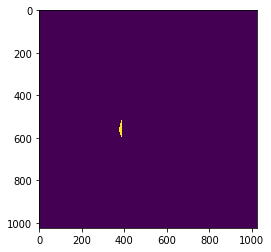

In [2]:
rle = '387620 23 996 33 986 43 977 51 968 58 962 65 956 70 952 74 949 76 946 79'
mask = run_length_decode(rle)
plt.imshow(mask)

### Activation maps, heatmaps, forward hooks, base model features

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

dataset = datasets.MNIST(
    root='PATH',
    transform=transforms.ToTensor(),
    download=True
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Batch idx {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img



In [ ]:
output.shape, pred.shape

In [ ]:
# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


In [ ]:

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))


In [ ]:

data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()


In [ ]:
data.shape, output.shape, act.shape

In [ ]:
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [ ]:
model_name = "densenet121"
model = Model(model_name, 5)

In [ ]:
model.model.features.norm5.register_forward_hook(get_activation('norm5'))

In [ ]:
#model.model.features.register_forward_hook()

In [ ]:
img = torch.rand(1, 3, 224, 224)
output = model(img)
img.shape, output.shape

In [ ]:
act = activation['norm5'].squeeze()

In [ ]:
act.shape

In [ ]:
avg_act = torch.mean(act, 0)

In [ ]:

plt.imshow(avg_act)

In [ ]:
scipy.optimize.minimize?

In [ ]:
arr = np.array([[1, 1, 1, 1, 1], [1, 1, 0, 0, 0], [1, 0, 1, 1, 0], [0, 0, 0, 0, 0]])
mask = arr == 0
np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

In [ ]:
mask

In [ ]:
mask.any(1), mask.argmax(1) 

In [ ]:
np.where(mask.any(1), mask.argmax(1), 5)

In [ ]:
np.where?

In [ ]:
target = [1, 2, 3, 4, 0, 1, 2, 3, 4]
NUM_CLASSES = 5
to_multi_label(target)

###  pycm analysis

In [ ]:
from pycm import *
y_actu = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2] # or y_actu = numpy.array([2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2])
y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2] # or y_pred = numpy.array([0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2])
cm = ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred) # Create CM From Data

In [ ]:
cm.ACC

In [ ]:
cm.stat()

In [ ]:
!ls

In [ ]:
cms = {}
cmfiles = glob('weights/5Jul_resnext101_32x4d_fold1/logs/*val*.obj')
for i in range(len(cmfiles)):
    cms[f"cm{i}"] = ConfusionMatrix(file=open(f"weights/5Jul_resnext101_32x4d_fold1/logs/cmval_{i}.obj","r"))

In [ ]:
cp = Compare(cms)

In [ ]:
print(cp)

In [ ]:
cms['cm0'].overall_stat

In [ ]:
save_folder = "weights"
phase = "val"
val_logger = Logger(os.path.join(save_folder, "logs/val"),)
train_logger = Logger(os.path.join(save_folder, "logs/train"))
#configure( flush_secs=5)

In [ ]:
metrics = ["Overall ACC", "Kappa", "TPR Micro", "PPV Micro", "F1 Micro", "Cross Entropy", ]
overall_stats = {x:[] for x in metrics}
for i in range(len(cmfiles)):
    for j in overall_stats.keys():
        overall_stats[j].append(cms["cm%d" % i].overall_stat[j])

In [ ]:
def log_all(name, data_list, logger):
    for idx, val in enumerate(data_list):
        logger.log_value(name, val, idx)

In [ ]:
for metric in metrics:
    log_all(metric, overall_stats[metric], val_logger)

In [ ]:
a = torch.Tensor([[0, 0, 1], [1, 0, 0]])

In [ ]:
torch.argmax(a, dim=1)

In [ ]:
torch.argmax?

In [ ]:
labels = [1, 0, 2, 3, 2, 3, 3, 3]
#np.eye(len(labels), 4)
#np.eye(4)[1]
len(np.unique(labels))kk

In [ ]:
!ls data

In [ ]:
train_df = pd.read_csv('data/train_labels.csv')
test_df = pd.read_csv('data/sample_submission.csv')

In [ ]:
test_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df.at[0, 'label'] = 1

In [ ]:
kfold = StratifiedKFold(20, shuffle=True, random_state=69)

In [ ]:
kfold.split(train_df['id'], train_df['label'])

In [ ]:
train_df.iloc[test]

In [ ]:
train_df.head()

In [ ]:
train_df.info(), test_df.info()

In [ ]:
%%time
img = mpimg.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

In [ ]:
timeit mpimg.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

In [ ]:
timeit pil_loader('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

In [ ]:
timeit cv2.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', flags=cv2.IMREAD_COLOR)

In [ ]:
timeit io.imread("data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")

In [ ]:
img = torch.Tensor(img)

In [ ]:
img.flip?

In [ ]:
torch.flip?

##### use cv2.imread for reading images 

In [ ]:
img.shape


In [ ]:
plt.imshow(img)

In [ ]:
# plot some random training images with their ground truth labels
i = random.choice(range(train_df.shape[0]))
img = mpimg.imread('data/train/' + train_df.iloc[i]['id'] + '.tif')
plt.imshow(img)
plt.title(train_df.iloc[i]['label'])
plt.show()

In [ ]:
train_df['label'].value_counts()

In [ ]:
train_df['label'].hist

In [ ]:
img = mpimg.imread('data/train/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif')
plt.imshow(img)
plt.show();
aug_img = train_aug(image=img)
plt.imshow(aug_img['image'])
plt.show();

### Dataloader analysis


In [18]:
import yaml
filepath = '../configs/278_unetresnet34_f1_test.yaml'
with open(filepath, 'r') as stream:
    try:
        cfg = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

cfg["num_workers"] = 0
cfg["batch_size"]["train"] = 1
cfg["batch_size"]["val"] = 1

dataloaders = {phase: provider(phase, cfg) for phase in ["train", "val"]}

(10675, 3)
(10675, 3)


### analyse augmentations 

In [63]:
def get_transforms(phase, cfg):
    size = cfg["size"]
    mean = eval(cfg["mean"])
    std = eval(cfg["std"])
    list_transforms = [
    ]
    if phase == "train":
        list_transforms.extend(
            [
                ShiftScaleRotate(
                    shift_limit=0.1,
                    scale_limit=0.1,
                    rotate_limit=10,
                    p=0.5,
                    border_mode=1 #cv2.BORDER_CONSTANT
                ),
 
            ]
        )

    list_transforms.extend(
        [
        albumentations.Normalize(mean=mean, std=std, p=1),
            AT.ToTensor(),
        ]
    )
    return albumentations.Compose(list_transforms)

In [64]:
phase = "train"
dataloader = dataloaders[phase]
dataloader.dataset.transforms = get_transforms(phase, cfg)

In [65]:
dataloader.dataset.transforms.transforms.transforms

[ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.1, 0.1), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-10, 10), interpolation=1, border_mode=1, value=None, mask_value=None),
 Normalize(always_apply=False, p=1, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
 ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None)]

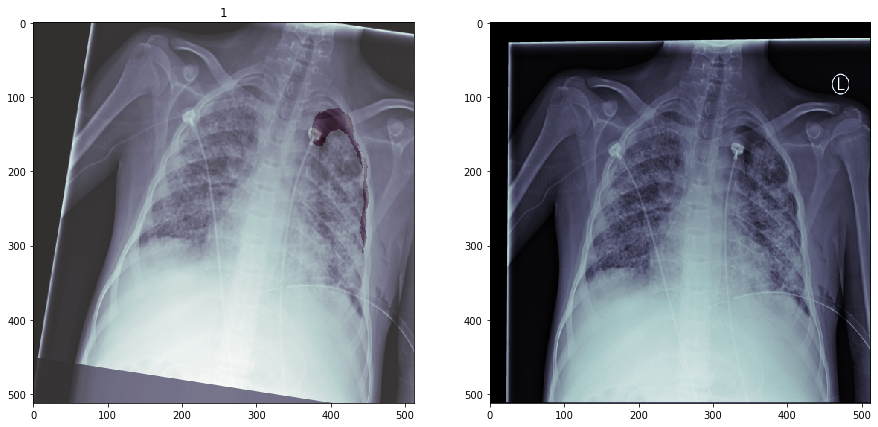

In [103]:
# plot some random training images with their ground truth labels
size = cfg['size']
# batch = next(iter(dataloaders['train']))
images, targets = batch
fnames = targets['image_id']
masks = targets['masks']
labels = targets['labels']
plt.figure(figsize=(15, 15))
#i = random.choice(range(len(images)))
i = 0 # as the batch size is 1
img = images[i].clone()[0, :, :]
mask = masks[i].clone()[0, :, :]
label = labels[i]
plt.subplot(1, 2, 1)
#img = targets['img'][0]
plt.imshow(img * 255, cmap='bone');
# if label.item() == 1:
plt.imshow(mask, alpha=0.2, cmap='Reds')
plt.title(str(label.item()))
plt.subplot(1, 2, 2)
#org_img = mpimg.imread(f'../data/train_png/{fnames[i]}.png')
#org_img = Image.open(f'../data/train_png/{fnames[i]}.png').convert('RGB')
org_img = cv2.imread(f'../data/train_png/{fnames[i]}.png', cv2.IMREAD_GRAYSCALE)
org_img = albumentations.Resize(size, size)(image=org_img)['image']
plt.imshow(org_img, cmap='bone'); # original image
# plt.imshow(mask, alpha=0.2, cmap='Reds')
plt.show(); 

In [114]:
np.unique(mask * 255)

array([0., 1.], dtype=float32)

In [110]:
np.load?

In [113]:
m = np.load('../data/npy_files/npy_masks_512/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.npy').astype('float32')
m.dtype
np.unique(m)

array([0.], dtype=float32)

In [104]:
torch.max(img), torch.min(img), torch.max(mask), torch.min(mask), np.max(org_img)

(tensor(1.8550), tensor(-2.1179), tensor(0.0039), tensor(0.), 255)

In [11]:
np.unique(mask, return_counts=True)

(array([0., 1.], dtype=float32), array([62765,  2771]))

In [81]:
import psutil
def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

show_ram_usage()

RAM usage: 0.8279800415039062 GB


In [97]:
df_path = os.path.join(cfg['home'], cfg['df_path'])
df = pd.read_csv(df_path)
df = df.drop_duplicates('ImageId')
df_with_mask = df.query('has_mask == 1')
#df = df_with_mask.copy()
df_without_mask = df.query('has_mask==0')
df_wom_sampled = df_without_mask.sample(len(df_with_mask))
df = pd.concat([df_with_mask, df_wom_sampled])


In [98]:
df.shape, df.drop_duplicates('ImageId').shape

((4758, 3), (4758, 3))

In [99]:
[x for x in df_with_mask.ImageId.tolist() if x in df_wom_sampled.ImageId.tolist()]

[]

In [100]:
fold = cfg['fold']
total_folds = cfg['total_folds']
kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]


In [101]:
[x for x in train_df.ImageId.tolist() if x in val_df.ImageId.tolist()]

[]

In [102]:
df = train_df.copy() if phase == "train" else val_df.copy()

In [96]:
df.sample?

#### rle mask kaggle function test

In [31]:
df = pd.read_csv('../data/train.csv')

In [36]:
org_rle = df.iloc[2]['EncodedPixels']
iid = df.iloc[2]['ImageId']
img = cv2.imread(f'../data/train_png/{iid}.png')


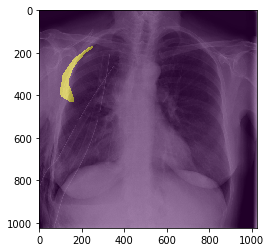

In [40]:
plt.imshow(img)
plt.imshow(rle2mask(org_rle, 1024, 1024), alpha=0.5)

rle2mask returns transposed mask

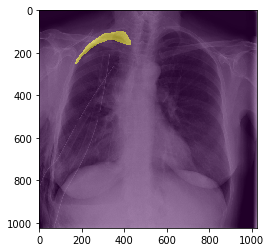

In [42]:
plt.imshow(img)
plt.imshow(run_length_decode(org_rle), alpha=0.5)

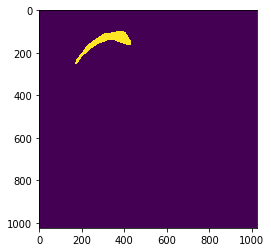

In [44]:
#let pred mask
pred = run_length_decode(org_rle)
plt.imshow(pred)

In [52]:
pred.shape, np.unique(pred)

((1024, 1024), array([0., 1.], dtype=float32))

In [53]:
rle1 = mask2rle(pred * 255, 1024, 1024)
rle2 = run_length_encode(pred)

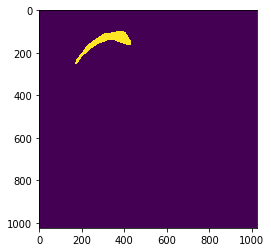

In [55]:
plt.imshow(rle2mask(rle1, 1024, 1024)) # mask2rle transposed output, rle2mask transposed input to correct output

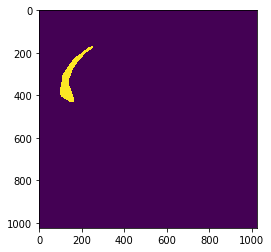

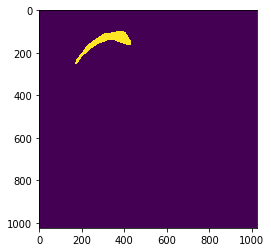

In [57]:
plt.imshow(run_length_decode(rle1)); plt.show()
plt.imshow(run_length_decode(rle2))

In [58]:
rle1, rle2

('101749 22 992 37 977 51 968 57 963 62 960 65 956 68 951 74 935 90 929 96 924 100 921 104 918 107 915 110 912 112 910 115 907 117 905 120 903 121 901 124 898 127 895 129 894 131 891 133 890 135 888 137 885 140 883 141 881 144 879 145 877 148 874 150 872 153 870 154 868 157 866 158 865 159 863 162 861 164 859 166 856 69 12 87 855 67 20 83 853 66 27 78 851 67 30 77 849 65 36 74 848 63 44 69 846 62 49 68 844 61 53 66 843 59 58 65 840 58 64 62 839 55 73 57 838 54 77 56 835 54 81 54 834 52 86 52 833 50 92 49 831 48 98 47 830 47 103 45 828 46 107 43 826 45 112 41 825 44 116 39 824 44 120 36 823 43 127 31 822 43 130 29 821 41 135 27 820 40 142 22 819 40 145 19 819 39 150 15 819 39 983 40 983 39 984 39 985 38 985 37 986 37 986 37 986 36 987 36 987 36 987 35 988 35 988 33 991 31 992 31 992 30 994 29 994 29 995 28 995 28 996 27 996 27 996 27 997 26 997 26 997 26 997 26 998 25 998 25 998 25 999 24 999 24 1000 24 999 24 999 24 999 24 999 23 1000 23 1000 23 1001 21 1002 21 1002 21 1002 20 1004 19 

In [16]:
np.unique(im)

array([  0,   4,  12,  20,  28,  32,  36,  60,  84,  95,  96, 100, 115,
       139, 155, 159, 171, 195, 219, 223, 227, 235, 243, 251, 255],
      dtype=uint8)

In [16]:
fnames[0]

'1.2.276.0.7230010.3.1.4.8323329.1426.1517875167.704674'

In [ ]:
rle = gb.get_group(fnames[0])['EncodedPixels'].tolist()
rle

In [ ]:

def run_length_decode(rle, height=1024, width=1024, fill_value=1):

    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component



In [ ]:
m = run_length_decode(rle[0])

In [ ]:
np.unique(m, return_counts=True), m.shape

In [ ]:
comp = np.zeros([5, 5])
comp = comp.flatten()
print(comp)
comp[2:5] = 1
print(comp)

In [ ]:
comp.reshape(5, 5).T

### augmentations testing

In [ ]:
img = np.load('../data/train_images/npy_rgb/a00b4cb250a7.npy')

In [ ]:
plt.imshow(img)

In [ ]:
np.min(img), np.max(img)

In [ ]:
albumentations.Normalize # Divide pixel values by 255, subtract mean per channel and divide by std per channel

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
norm = albumentations.Normalize(mean=mean, std=std, p=1)
norm_img = norm(image=img)['image']

In [ ]:
np.min(norm_img), np.max(norm_img), norm_img[0, 0, 0]

In [ ]:
norm_img.dtype

In [ ]:
albumentations.torch.ToTensor? # convert image and mask to torch.Tensor and divide by 255 if image or mask are `uint8` type, use with care look into sources

In [ ]:
albumentations.Normalize?

In [ ]:
mean = torch.as_tensor([0.485, 0.456, 0.406])
std = torch.as_tensor([0.229, 0.224, 0.225])
#return (img * std) + mean
#return img.mul_(std).add_(mean)
labels[i].item()

In [ ]:
mean, std, mean.shape, std.shape

### pretrained models testing

In [ ]:
import pretrainedmodels
pretrainedmodels.model_names

In [ ]:
pretrainedmodels.pretrained_settings['resnext101_32x4d']

In [ ]:
summary(model2, input_size=(3, 224, 224), device="cpu")

In [ ]:
import torch
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')

In [ ]:
model.fc

In [ ]:
model.avgpool

In [ ]:
model.children()

In [ ]:
blocks = list(model.children())

In [ ]:
backbone = nn.Sequential(
    *list(blocks[:-2])
) # upto AdaptiveAvgPool2d

In [ ]:
backbone

In [ ]:
nn.AvgPool2d?

In [ ]:
# model_name='se_resnext50_32x4d'
model_name= "resnext101_32x4d"#'nasnetamobile'
model_name = "resnet50"
#model_name = "densenet121"

model = pretrainedmodels.__dict__[model_name](num_classes=1000)

In [ ]:
#list(model.children())
model

In [ ]:
#model.features

In [ ]:
# blocks = list(model.children())
# # blocks[:-3]
# model

In [ ]:
blocks = list(model.children())
head = torch.nn.Sequential(*list(model.children())[:-3])
# model._modules['layer0'] = head
#model._modules['avg_pool'] = torch.nn.AvgPool2d(kernel_size=5, stride=1, padding=0) 
#model._modules['avg_pool'] = torch.nn.Sequential(*[torch.nn.ConstantPad2d((0,1,0,1), 0), torch.nn.AvgPool2d(kernel_size=7, stride=1, padding=0)])
# model._modules['avg_pool'] = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((1, 1)))
# model._modules['last_linear'] = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
# model._modules['last_layer'] = classifier

In [ ]:
torch.nn.AdaptiveAvgPool2d?

In [ ]:
#head.parameters()
#for block in blocks:
base = list(blocks[0].children())[:-1] + blocks[1:-2]
torch.nn.Sequential(*base)
torch.nn.Dropout?
#    print(block)
#    print('*'*100)

In [ ]:

torch.nn.Linear?

In [ ]:
#blocks[0] = head

In [ ]:
#blocks[-1] = torch.nn.Linear(in_features=2048, out_features=1, bias=True)

In [ ]:
#model = torch.nn.Sequential(*blocks)

In [ ]:
#model._modules

In [ ]:
img = torch.Tensor(1, 3, 224, 224)#.to('cuda')
#img = torch.Tensor(1, 3, 112, 112)
#img = torch.Tensor(1, 3, 96, 96)

In [ ]:
out = model(img)
features = model.features(img)
print(features.shape, out.shape)

In [ ]:
nn.AdaptiveAvgPool2d((1, 1))(features).shape

In [ ]:
x = None
for param in model.features.children():
    
    print(param)
    if x is None:
        x = param(img)
    else:
        x = param(x)
    print(x.shape)

In [ ]:
# summary(model, input_size=(3, 96, 96))
# summary(model, input_size=(3, 112, 112))
summary(model.features, input_size=(3, 224, 224))

In [ ]:
torch.nn.functional.max_pool2d
torch.nn.functional.adaptive_avg_pool2d?

In [ ]:
# torch.nn.Dropout?

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)




In [ ]:
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained="imagenet")
backbone = model.features
classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=1056, out_features=1, bias=True)
        )



In [ ]:
img = torch.Tensor(1, 3, 112, 112)
features = backbone(img)


In [ ]:
model.parameters()

In [ ]:
 
from albumentations import *

In [ ]:
train_aug = Compose([
    Resize(224, 224),
    RandomRotate90(p=0.5),
    Transpose(p=0.5),
    Flip(p=0.5),
    OneOf([CLAHE(clip_limit=2), IAASharpen(), IAAEmboss(), RandomBrightnessContrast(), JpegCompression(), Blur(), GaussNoise() ], p=0.5), 
    HueSaturationValue(p=0.5), 
    ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
    Normalize(p=1)
])
val_aug = Compose([
    Normalize(p=1)
])


In [ ]:
ShiftScaleRotate?

In [ ]:
Normalize?

In [ ]:
train_aug?

In [ ]:
flip = Flip(p=1)

In [ ]:
flip.apply?

### AUC ROC

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)
# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]


In [ ]:
testy.shape, probs.shape

In [ ]:
fpr, tpr, thresholds

In [ ]:
# calculate AUC
auc = roc_auc_score(testy, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [ ]:
pyplot.savefig('lol.png')

In [ ]:
pyplot.close('all')

In [ ]:
import apex

In [ ]:
apex.amp.?

In [ ]:
import pandas as pd
df1 = pd.read_csv('weights/ensemble/11Mar_nasnetamobile_fold0_ckpt17.csv')
df2 = pd.read_csv('weights/ensemble/9Mar_se_resnext50_32x4d_v3_fold0_1_2_allckpt17.csv')
df3 = pd.read_csv('weights/ensemble/11Mar_nasnetamobile_v2_fold2_ckpt20.csv')
df= df1.copy()
df['label'] = (df1['label'] + df3['label'] + 3* df2['label'])/5

In [ ]:
df.head()

In [ ]:
df.to_csv('weights/ensemble/resnextfold012ckpt17+nasnetmobileckpt17+nasnetamobilefold2_ckpt20.csv', index=False)

### TEST

In [5]:
img = np.load('../data/npy_train/1.2.276.0.7230010.3.1.4.8323329.10137.1517875222.275005.npy')
mask = np.load('../data/npy_masks/1.2.276.0.7230010.3.1.4.8323329.10137.1517875222.275005.npy')
img.shape, mask.shape

((1024, 1024, 1), (0, 2))